# CA2 Part 2 (Unsupervised Learning)

Done By: Darius Khoo  
  

Admin Number: 2222259  
  

Class: DAAA/FT/2A/06  
  

---

### **Background**
You are running a shopping mall, and you have some data about your customers like
Age, Gender, Income and Spending.

### **Task** 
- Perform customer segmentation using Unsupervised Learning algorithms.

- Describe the characteristics of each customer cluster.

- Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them.

In [432]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

rng = np.random.RandomState(42)

from warnings import filterwarnings 
filterwarnings('ignore')

df = pd.read_csv('./data/Customer_Dataset.csv')


# what i need to do 
# create a pipeline 
# finish the function to extract analysis of each cluster
# loop through multiple K values and evaluate them using 2 methods 
# 1. plotting the plots, getting the information
# see if can narrow down the models if not proceed to tuning
# steps are already provided below
# get the final clustering model, unstandardize it and get information based on it

In [433]:
# Functions

## *Exploratory Data Analysis*



---

In [434]:
df.head(8)

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [436]:
df.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Analysis


---

## Univariate Analysis

In [437]:
# sns.displot(x='Income (k$)', kde=True, height=8, data=df)
# plt.title('Distribution of Income')
# plt.show()


In [438]:
# sns.displot(x='How Much They Spend', kde=True, height=8, data=df, color='black')
# plt.title('Distribution of Spending')
# plt.show()


In [439]:
# sns.displot(x='Age', kde=True, height=8, data=df, color = 'orange')
# plt.title('Distribution of age of customers')
# plt.show()

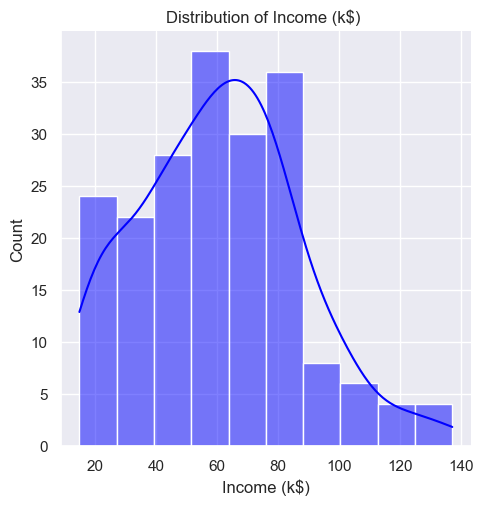

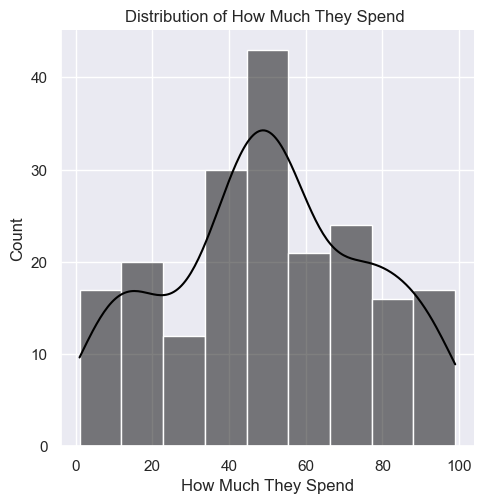

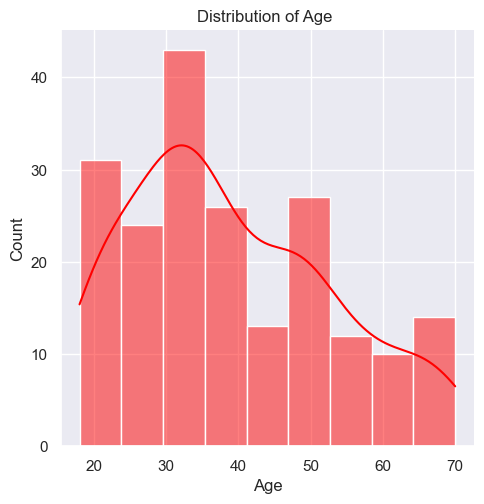

In [440]:
# Define the x-axis values and colors
x_values = ['Income (k$)', 'How Much They Spend', 'Age']
colors = ['blue', 'black', 'red']

# Loop through the x_values and colors
for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

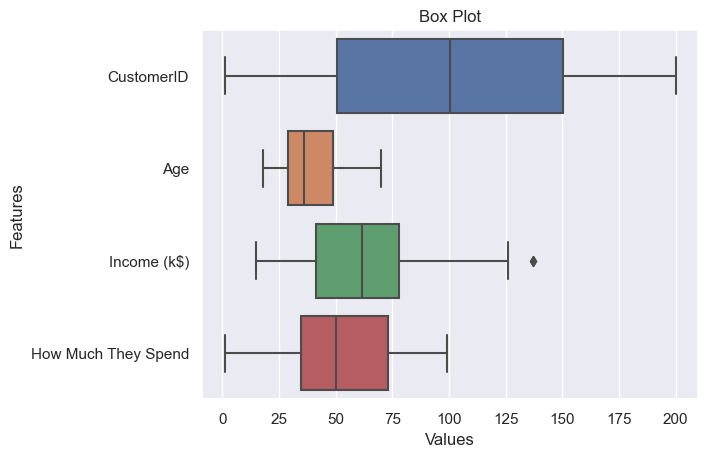

In [441]:
sns.boxplot(data=df , orient= 'h')

# Set labels and title
plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

# Show the plot
plt.show()

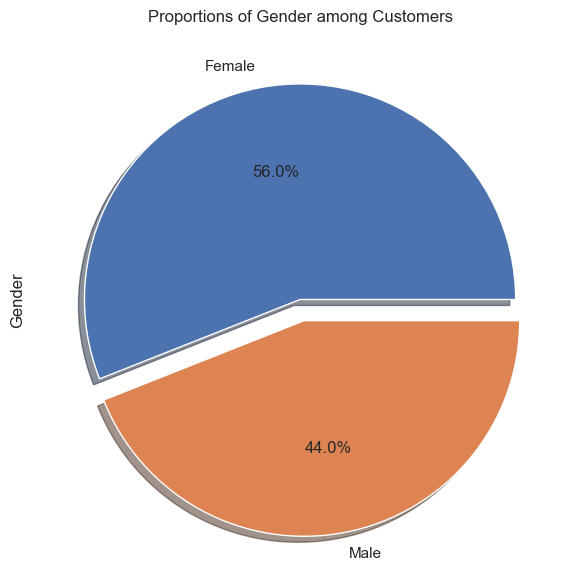

In [442]:
# pie chart on resign status
fig, ax = plt.subplots(figsize=(10, 7))
fig.set_facecolor("white")
df["Gender"].value_counts().plot.pie(
    title="Proportions of Gender among Customers",
    legend=False,
    autopct="%1.1f%%",
    explode=(0, 0.1),
    shadow=True,
    startangle=0,
)
plt.show()

---

## Visualizing the dataset as a whole

In [443]:
df = pd.read_csv('./data/Customer_Dataset.csv')
# df = df.drop('CustomerID', axis=1)
df

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


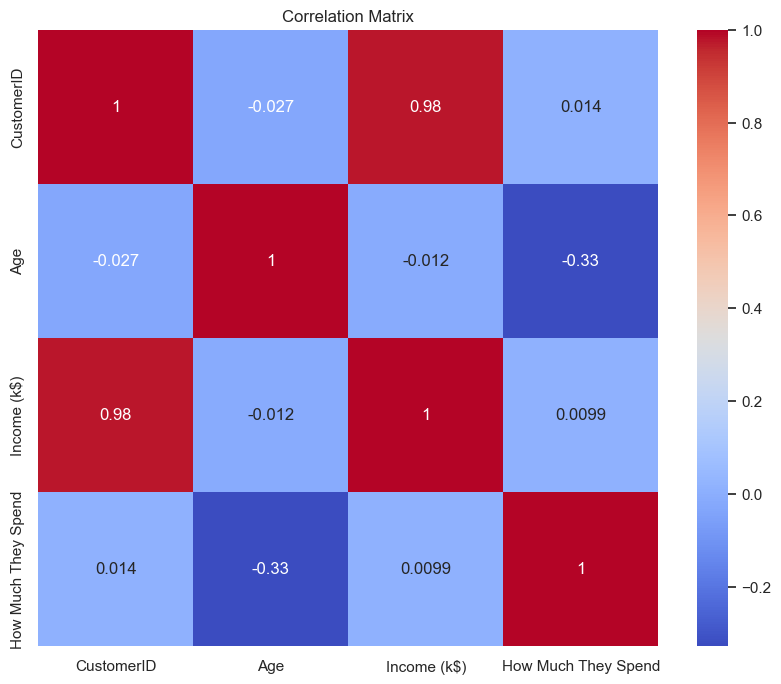

In [444]:
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

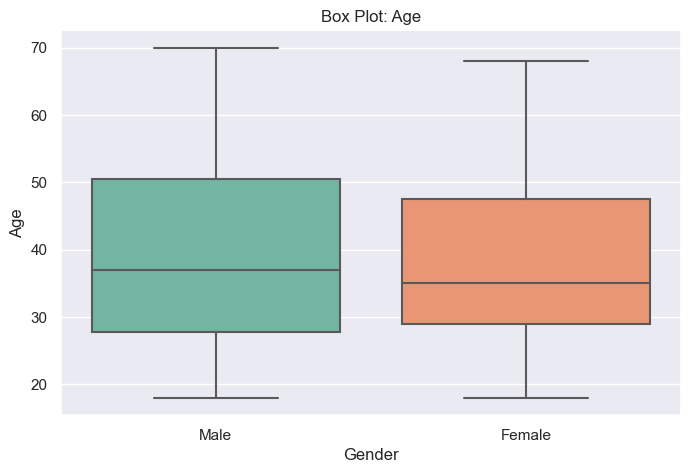

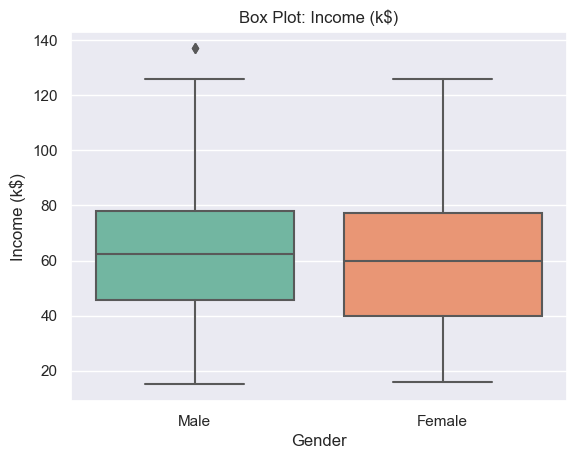

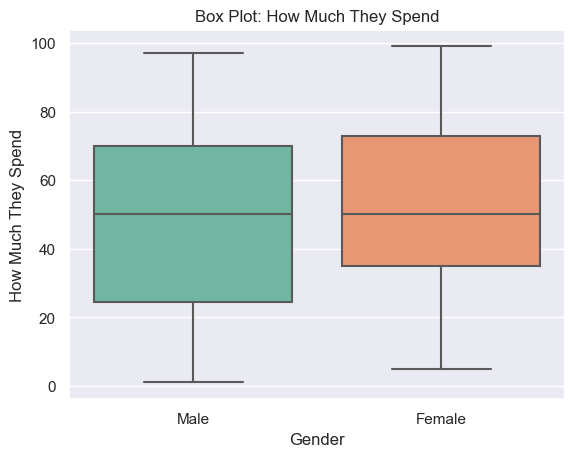

In [445]:
plt.figure(figsize=(8, 5))

for feature in df.columns:
    if feature != 'Gender' and feature != 'CustomerID':  # Exclude the Gender and Customer ID column
        sns.boxplot(x='Gender', y=feature, data=df, palette='Set2')
        plt.title(f"Box Plot: {feature}")
        plt.xlabel("Gender")
        plt.ylabel(feature)
        plt.show()

---

## Data Preprocessing

Just like most machine learning project data preprocessing is an important step consisting of

- Data Encoding
- Data Scaling
- Dimension Reduction

just to name a few of the possible steps, now lets apply preprocessing for our data

Our dataset is actually quite small with only a few features which is a good thing, however we still have 1 categorical value that we need to encode that being Gender, however we need to take note of the scaler we use as scalers like OneHotEncoder will add new columns effectively creating more dimensions for our model in the future

There are a few encoders we could use

- LabelEncoder
- OneHotEncoder
- OrdinalEncoder

Since our only categorical column being Gender with the values consisting of either Male or Female, OneHotencoder's problem of creating extra dimension will not affect our data since its either 1 or 0 for each gender so we will use OneHotEncoder

In [446]:
df = pd.read_csv('./data/Customer_Dataset.csv')
df = df.drop('CustomerID', axis=1)
df

,Gender,Age,Income (k$),How Much They Spend
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [447]:
encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(df[['Gender']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Gender']))
data_encoded = df.drop(['Gender'], axis=1)

# add the encoded data to the original data
data_encoded = pd.concat([data_encoded, encoded_df], axis=1)
data_encoded = data_encoded.drop(['Gender_Male'], axis=1)

data_encoded

,Age,Income (k$),How Much They Spend,Gender_Female
0,19,15,39,0.0
1,21,15,81,0.0
2,20,16,6,1.0
3,23,16,77,1.0
4,31,17,40,1.0
...,...,...,...,...
195,35,120,79,1.0
196,45,126,28,1.0
197,32,126,74,0.0
198,32,137,18,0.0


Analysis

In [448]:
# # Clustering silhouette_score
# from sklearn.metrics import silhouette_score
# from sklearn.datasets import load_iris
# from sklearn.cluster import KMeans
# X = load_iris().data
# # trying different number of clusters
# for k in range(2, 11):
#  model = KMeans(n_clusters=k).fit(data_encoded)
#  label = model.labels_
#  sil_coeff = silhouette_score(data_encoded, label, metric='euclidean')
#  print("For n_clusters={}, The Silhouette Coefficient is {:.3f}".format(k,
# sil_coeff))

In [449]:
# df = pd.read_csv('./data/Customer_Dataset.csv')
# # Convert gender to numerical values (e.g., 0 for male, 1 for female)
# df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# # Perform K-means clustering with gender as a feature
# k = 6  # Number of clusters
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(data_encoded)

# # Calculate the silhouette score
# labels = kmeans.labels_
# silhouette_avg = silhouette_score(df, labels)

# print("Silhouette Score:", silhouette_avg)

In [450]:
# df_testing = data_encoded.drop('Gender_Female', axis=1)


# k = 6 # Number of clusters
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(df_testing)

# # Calculate the silhouette score
# labels = kmeans.labels_
# silhouette_avg = silhouette_score(df_testing, labels)

# print("Silhouette Score without Gender:", silhouette_avg)

Since the variance and mean has not a significant difference we can proceed with dropping it 


### Standardization and Normalization

i will choose standardization 


In [451]:
columns_to_scale = ['Income (k$)', 'How Much They Spend', 'Age']


# Create a subset of the DataFrame with the selected columns
data_subset = data_encoded[columns_to_scale]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
scaled_data = scaler.fit_transform(data_subset)

# Replace the original values with the scaled values
data_encoded[columns_to_scale] = scaled_data

In [452]:
data_encoded

,Age,Income (k$),How Much They Spend,Gender_Female
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,1.0
196,0.441365,2.497807,-0.861839,1.0
197,-0.491602,2.497807,0.923953,0.0
198,-0.491602,2.917671,-1.250054,0.0


## Feature Engineering 

as we have seen above the difference in gender might not be very different 

we can see similar variance hence we can proceed with the test
i will be checking using a few test

- 2 sample t-test
- silhouette score

In [453]:
data_encoded.groupby('Gender_Female').var()

,Age,Income (k$),How Much They Spend
Gender_Female,,,
0.0,1.239763,1.033824,1.172881
1.0,0.823420,0.985774,0.876433


In [454]:
def two_sample_t_test(data, col, level = 'Gender_Female', equal_variances = True, significance_level = 0.05):
    pivoted_data = data.pivot(columns=level)[col]
    a, b = pivoted_data.iloc[:, 0].dropna(), pivoted_data.iloc[:, 1].dropna()
    text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are equal\nH1 : Population means are not equal\nSignificance Level = {significance_level}"
    #text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are not equal\nH1 : Population means are equal\nSignificance Level = {significance_level}"
    print(text)
    t_score, pvalue = stats.ttest_ind(a, b, equal_var=equal_variances)
    print("The p-value is", pvalue)
    if pvalue > significance_level:
        print("There is insufficient evidence to reject the null hypothesis that the population means are equal.")
    else:
        print("There is evidence to reject the null hypothesis that the population means are equal.")

In [455]:
for col in ('Age', 'Income (k$)', 'How Much They Spend'):
    print(col)
    two_sample_t_test(data_encoded, col)
    print()

Age
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.39189073778825656
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Income (k$)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.42755249399927864
There is insufficient evidence to reject the null hypothesis that the population means are equal.

How Much They Spend
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.41374465898521817
There is insufficient evidence to reject the null hypothesis that the population means are equal.



so lets just drop Gender column 

In [456]:
final_df = data_encoded.drop('Gender_Female', axis=1)


In [457]:
final_df

,Age,Income (k$),How Much They Spend
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [470]:
df = df.drop('Gender', axis=1)


---

In [458]:
# from scipy.stats import ttest_ind

# def perform_ttest1(df, column_list, group_column):
#     results = []
    
#     for column in column_list:
#         group1 = df[df[group_column] == 0][column]
#         group2 = df[df[group_column] == 1][column]
        
#         t_statistic, p_value = ttest_ind(group1, group2, equal_var=True)
        
#         results.append({
#             'Column': column,
#             'T-Statistic': t_statistic,
#             'P-Value': p_value
#         })
    
#     return pd.DataFrame(results)




In [459]:
# columns_to_compare = ['Income (k$)', 'How Much They Spend', 'Age']
# group_column = 'Gender'

# result_df = perform_ttest1(df, columns_to_compare, group_column)
# print(result_df)

In [460]:
# import numpy as np
# from scipy.stats import ttest_ind

# def two_sample_ttest(sample1, sample2, alpha=0.05):
#     """
#     Perform a two-sample t-test assuming equal population means.
    
#     Args:
#         sample1 (array-like): First sample data.
#         sample2 (array-like): Second sample data.
#         alpha (float): Significance level (default: 0.05).
        
#     Returns:
#         t_statistic (float): T-statistic.
#         p_value (float): P-value.
#         result (str): Result of the hypothesis test.
#     """
#     t_statistic, p_value = ttest_ind(sample1, sample2)
    
#     if p_value < alpha:
#         result = "Reject the null hypothesis. There is evidence of a significant difference in means."
#     else:
#         result = "Fail to reject the null hypothesis. There is no evidence of a significant difference in means."
    
#     return t_statistic, p_value, result

# *Clustering* 

we will be using a few models to try and cluster our data which includes

- KMeans
- DBSCAN
- Agglomerative Hierarchical Clustering


## KMeans
with KMeans we need to specify the number of clusters we want to have, however we don't know what that value is so i will loop through multiple value and evaluate the results on multiple factors being:  
>`Silhouette Analysis`, `Elbow Plot(Inertia)`

In [480]:
def clusters_inertia(data, max_clusters):
    inertias = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        inertias.append(inertia)

    return inertias

def clusters_silhouette(data, max_clusters):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_score_val = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_score_val)

    return silhouette_scores


In [488]:
max_clusters = 20
x_values = list(range(2, max_clusters + 1))
inertias = clusters_inertia(final_df, max_clusters)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=inertias, mode='lines'))

fig.update_layout(
    title='Elbow Plot',
    xaxis_title='Number of Clusters',
    yaxis_title='Inertia'
)

fig.show()

Lower the inertia the better


In [486]:
max_clusters = 20
x_values = list(range(2, max_clusters + 1))
silhouette_scores = clusters_silhouette(final_df, max_clusters)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=silhouette_scores, mode='lines'))

fig.update_layout(
    title='Elbow Plot',
    xaxis_title='Number of Clusters',
    yaxis_title='Silhouette Score'
)

fig.show()

higher the silhouette score the better

6-10

In [471]:
#  Get the Analysis of each cluster (Mean of each feature in that cluster)
def cluster_analysis(data, labels):
    cluster_analysis = pd.DataFrame(columns=data.columns)
    
    for cluster in np.unique(labels):
        cluster_data = data[labels == cluster]
        cluster_average = cluster_data.mean()
        
        cluster_analysis.loc[cluster] = cluster_average
    
    cluster_analysis['Cluster'] = np.unique(labels)
    
    return cluster_analysis

In [475]:
kmeans = KMeans(n_clusters=5, random_state=42)
data_points = final_df.values
labels = kmeans.fit_predict(data_points)

analysis_result = cluster_analysis(df, labels)

analysis_result

,Age,Income (k$),How Much They Spend,Cluster
0,55.638298,54.382979,48.851064,0
1,32.875000,86.100000,81.525000,1
2,25.185185,41.092593,62.240741,2
3,46.250000,26.750000,18.350000,3
4,39.871795,86.102564,19.358974,4


# References

---

# Chicken Parmesan Recipe

## Ingredients
- 2 boneless, skinless chicken breasts
- 1 cup bread crumbs
- 1/2 cup grated Parmesan cheese
- 1/2 cup all-purpose flour
- 2 large eggs, beaten
- 1 cup marinara sauce
- 1 cup shredded mozzarella cheese
- 2 tablespoons olive oil
- Salt and pepper, to taste

## Instructions
1. Preheat the oven to 375°F (190°C).
2. In a shallow bowl, mix together the bread crumbs and grated Parmesan cheese.
3. Season the chicken breasts with salt and pepper.
4. Dredge each chicken breast in the flour, dip it into the beaten eggs, and then coat it with the bread crumb mixture.
5. In a large skillet, heat the olive oil over medium-high heat.
6. Add the breaded chicken breasts to the skillet and cook until golden brown on both sides, about 3-4 minutes per side.
7. Remove the chicken from the skillet and place it in a baking dish.
8. Pour the marinara sauce over the chicken breasts, covering them evenly.
9. Sprinkle the shredded mozzarella cheese over the top.
10. Bake in the preheated oven for 20-25 minutes, or until the chicken is cooked through and the cheese is melted and bubbly.
11. Remove from the oven and let it rest for a few minutes before serving.
12. Serve the Chicken Parmesan hot with pasta or a side of your choice.

Enjoy your delicious Chicken Parmesan!